In [ ]:
!pip install pmdarima
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from matplotlib import font_manager
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로딩

In [ ]:
stocks_data = pd.read_csv('sp500_stocks.csv')
companies_data = pd.read_csv("sp500_companies.csv")

In [ ]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
stocks_data.index = stocks_data['Date']
stocks_data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,,
2010-01-04,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0
2010-01-05,2010-01-05,MMM,43.741024,68.979935,69.590302,68.311035,69.230766,3405012.0
2010-01-06,2010-01-06,MMM,44.361340,69.958191,70.735786,69.824417,70.133781,6301126.0
2010-01-07,2010-01-07,MMM,44.393169,70.008362,70.033447,68.662209,69.665550,5346240.0
2010-01-08,2010-01-08,MMM,44.705978,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
2024-10-16,2024-10-16,ZTS,194.440002,194.440002,195.880005,191.759995,192.000000,1591500.0
2024-10-17,2024-10-17,ZTS,191.000000,191.000000,196.550003,190.889999,195.710007,1701200.0
2024-10-18,2024-10-18,ZTS,193.279999,193.279999,193.490005,190.500000,191.160004,1576400.0


# EDA

### 결측값 확인

In [ ]:
stocks_data.isnull().sum()

,0
Date,0
Symbol,0
Adj Close,101626
Close,101626
High,101626
Low,101626
Open,101626
Volume,101626


## 분기별 결측값 갯수

In [ ]:
missing_counts_by_date = stocks_data.isnull().any(axis=1).astype(int)
missing_counts_by_quarter = missing_counts_by_date.resample('Q').sum()
missing_counts_by_quarter.index = missing_counts_by_quarter.index.to_series().apply(lambda x: f"{x.year}년 {x.quarter}분기")
missing_counts_by_quarter

<ipython-input-8-bf49d26ad955>:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  missing_counts_by_quarter = missing_counts_by_date.resample('Q').sum()


,0
Date,
2010년 1분기,4359
2010년 2분기,4414
2010년 3분기,4258
2010년 4분기,4164
2011년 1분기,3848
2011년 2분기,3775
2011년 3분기,3776
2011년 4분기,3632
2012년 1분기,3496


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


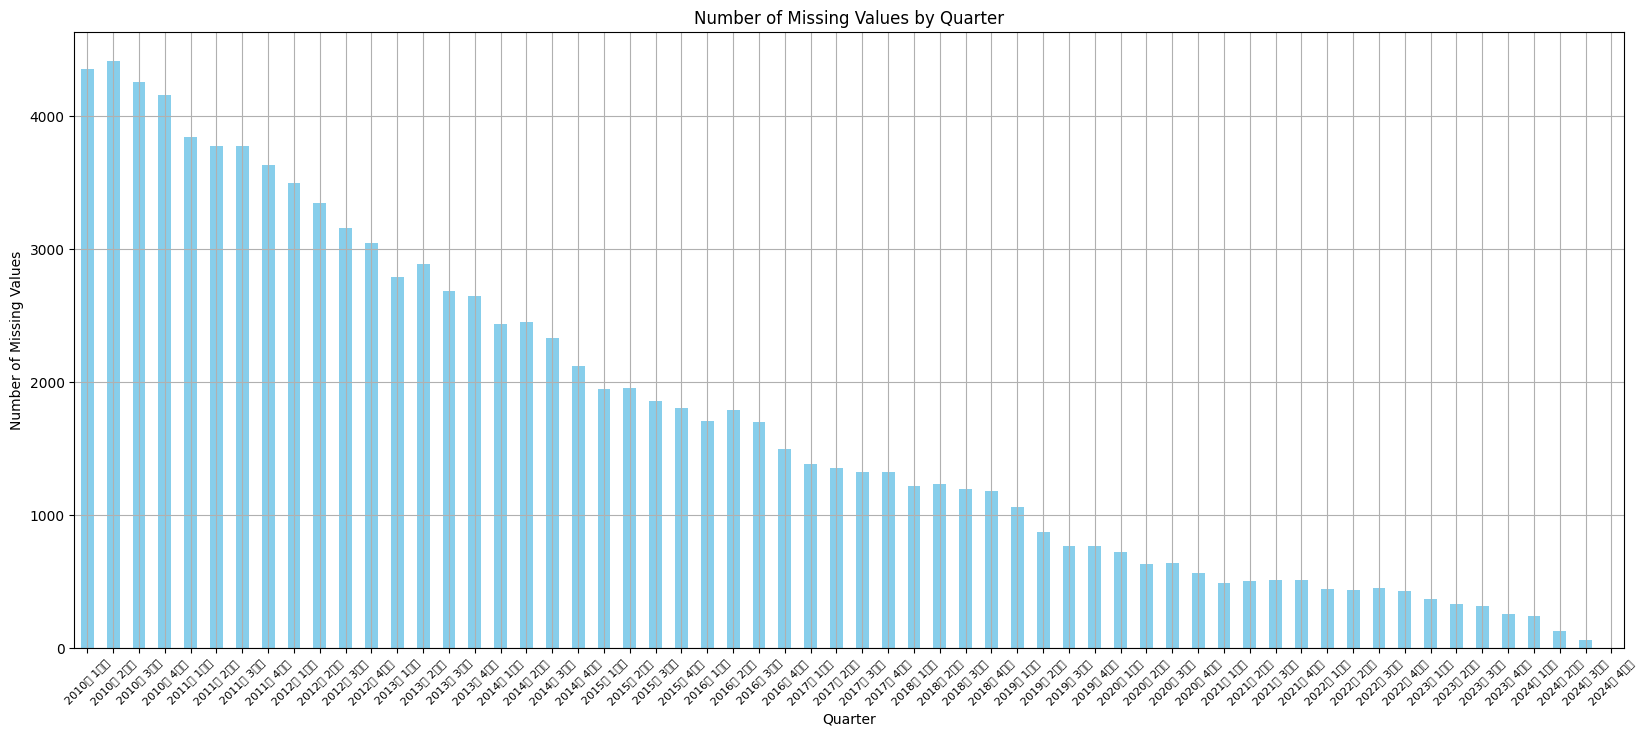

In [ ]:
plt.figure(figsize=(20, 8))
missing_counts_by_quarter.plot(kind='bar', color='skyblue')

plt.title('Number of Missing Values by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45,fontsize=8)
plt.grid(True)

plt.show()

## 종목별 결측값 갯수

In [ ]:
missing_symbols = stocks_data[stocks_data.isnull().any(axis=1)]['Symbol'].unique()
print("결측값이 있는 종목들:", missing_symbols)

missing_dates = stocks_data.isnull().any(axis=1).astype(int)
missing_counts_by_symbol = missing_dates.groupby(stocks_data['Symbol']).sum()
missing_counts_filtered = missing_counts_by_symbol[missing_counts_by_symbol > 0].sort_values(ascending=False)
missing_counts_filtered

결측값이 있는 종목들: ['ABBV' 'ABNB' 'ALLE' 'AMCR' 'AMTM' 'APTV' 'ANET' 'CZR' 'CARR' 'CTLT'
 'CBOE' 'CDW' 'CHTR' 'CFG' 'CEG' 'CPAY' 'CTVA' 'CRWD' 'DAY' 'DELL' 'FANG'
 'DOW' 'ENPH' 'EPAM' 'FTV' 'FOXA' 'FOX' 'GEHC' 'GEV' 'GNRC' 'GM' 'GDDY'
 'HCA' 'HPE' 'HLT' 'HWM' 'HII' 'IR' 'INVH' 'IQV' 'KVUE' 'KEYS' 'KMI' 'KKR'
 'KHC' 'LW' 'LYB' 'MPC' 'META' 'MRNA' 'NWSA' 'NWS' 'NCLH' 'NXPI' 'OTIS'
 'PLTR' 'PANW' 'PAYC' 'PYPL' 'PSX' 'QRVO' 'NOW' 'SW' 'SOLV' 'SYF' 'TRGP'
 'TSLA' 'UBER' 'VLTO' 'VICI' 'VST' 'XYL' 'ZTS']


,0
Symbol,
AMTM,3705
SW,3650
SOLV,3583
GEV,3583
VLTO,3461
...,...
TSLA,122
CBOE,112
LYB,79


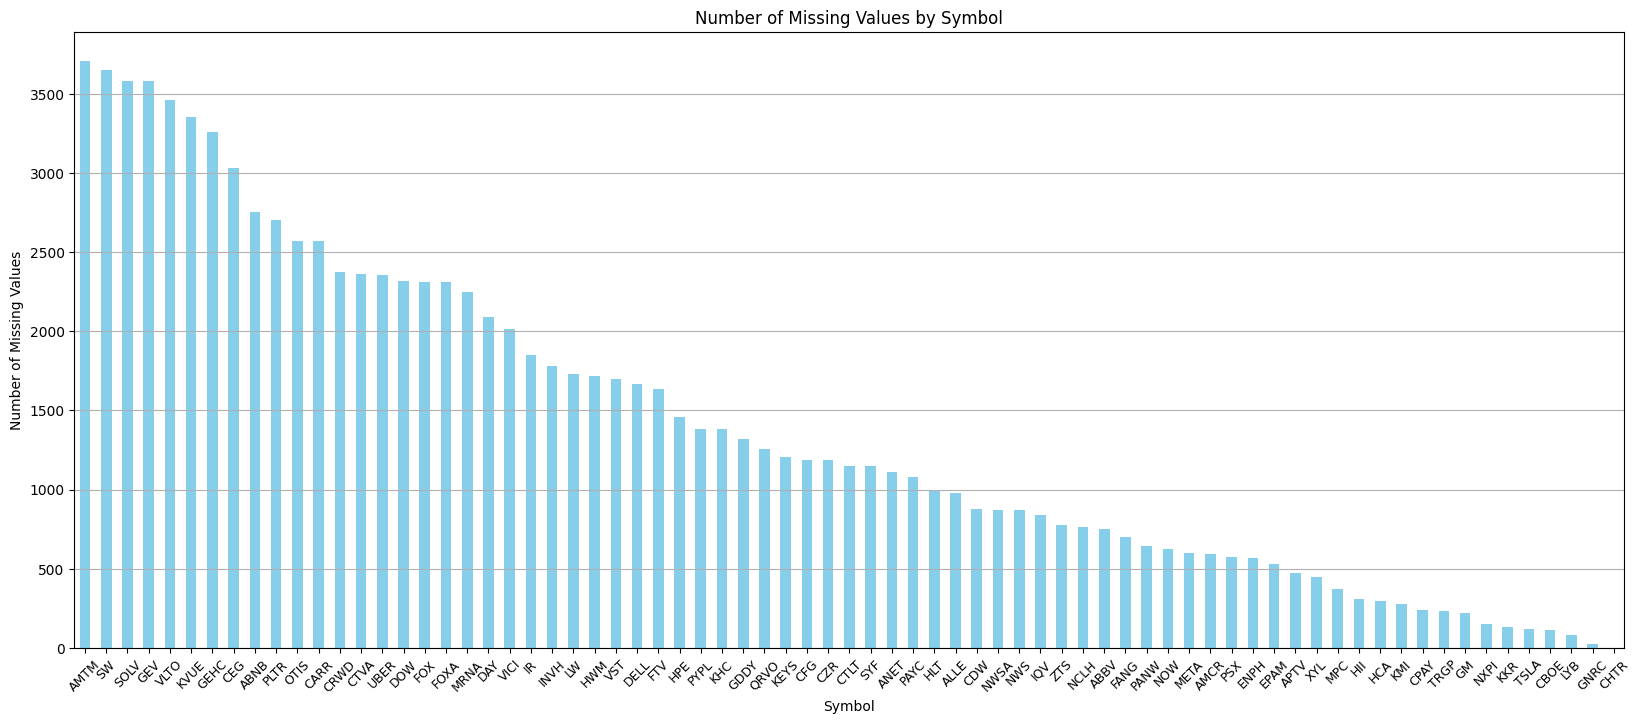

In [ ]:
plt.figure(figsize=(20, 8))
missing_counts_filtered.plot(kind='bar', color='skyblue')

plt.title('Number of Missing Values by Symbol')
plt.xlabel('Symbol')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, fontsize=9)
plt.grid(axis='y')

plt.show()

# 데이터 전처리

## 결측값 처리(선형보간법)

In [ ]:
# nan_data = stocks_data[stocks_data.isnull().any(axis=1)]
for i in ['Adj Close','Close',	'High',	'Low',	'Open',	'Volume']:
  stocks_data[i] = stocks_data[i].interpolate(method='linear')
stocks_data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,,
2010-01-04,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0
2010-01-05,2010-01-05,MMM,43.741024,68.979935,69.590302,68.311035,69.230766,3405012.0
2010-01-06,2010-01-06,MMM,44.361340,69.958191,70.735786,69.824417,70.133781,6301126.0
2010-01-07,2010-01-07,MMM,44.393169,70.008362,70.033447,68.662209,69.665550,5346240.0
2010-01-08,2010-01-08,MMM,44.705978,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
2024-10-16,2024-10-16,ZTS,194.440002,194.440002,195.880005,191.759995,192.000000,1591500.0
2024-10-17,2024-10-17,ZTS,191.000000,191.000000,196.550003,190.889999,195.710007,1701200.0
2024-10-18,2024-10-18,ZTS,193.279999,193.279999,193.490005,190.500000,191.160004,1576400.0


## 산업별 데이터 셋 만들기

In [ ]:
merged_df = pd.merge(stocks_data, companies_data[['Symbol', 'Sector']], on='Symbol')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)
sector_grouped_data = merged_df.groupby(['Date', 'Sector'])['Adj Close'].mean().unstack()
sector_grouped_data

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
Date,,,,,,,,,,,
2010-01-04,67.768160,26.223404,67.232462,42.948161,38.932261,35.918412,42.723817,32.382947,26.324526,156.504655,35.751053
2010-01-05,67.576828,25.433189,67.457915,43.000720,39.061398,36.043605,42.594005,32.458707,26.415036,155.707815,35.584715
2010-01-06,67.875742,25.311814,67.227101,43.087911,39.333641,35.943241,42.562907,32.520262,26.364385,154.913418,35.667347
2010-01-07,67.590930,25.248398,67.603177,43.072526,39.247913,36.229946,42.729360,32.709287,26.440932,154.107630,35.583742
2010-01-08,67.541231,25.202706,67.451802,42.978734,39.395101,36.184746,42.750934,32.956107,26.262026,153.420256,35.563011
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-16,168.911367,141.294772,469.965454,110.948984,86.085455,203.600838,245.962594,247.149290,145.788712,246.669391,93.052813
2024-10-17,169.508182,140.431363,468.979456,110.571701,86.648637,203.859603,243.204577,247.419967,145.368709,246.932194,91.973437
2024-10-18,170.414545,143.915454,472.530187,110.754865,86.491364,203.883731,244.577381,247.968286,146.433549,246.391584,92.450937


In [ ]:
sector_dataframes = {}
for column in sector_grouped_data.columns:
    sector_dataframes[column] = sector_grouped_data[[column]].rename(columns={column: 'Adj Close'})

In [ ]:
sector = 'Consumer Cyclical'
sector_data = sector_dataframes[sector]

In [ ]:
# plt.figure(figsize=(12, 8))
# for sector in sector_data.columns:
#     plt.plot(sector_data.index, sector_data[sector], label=sector)

# plt.xlabel('Date')
# plt.ylabel('Average Adjusted Close Price')
# plt.title('Sector-wise Average Stock Price Over Time')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()



## 종목별 데이터 셋 만들기



In [ ]:
symbol_groups = {symbol: group for symbol, group in stocks_data.groupby('Symbol')}
symbol = "AAPL"
symbol_data = symbol_groups[symbol]['Adj Close']
interval = 200
interval2 = 50
rolmean50 =  symbol_data.rolling(interval2).mean()
rolmean200 =  symbol_data.rolling(interval).mean()
rolstd = symbol_data.rolling(interval).std()

<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.savefig(f"{symbol}_graph.png")
<ipython-input-18-8902fb9ebef8>:9: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from cu

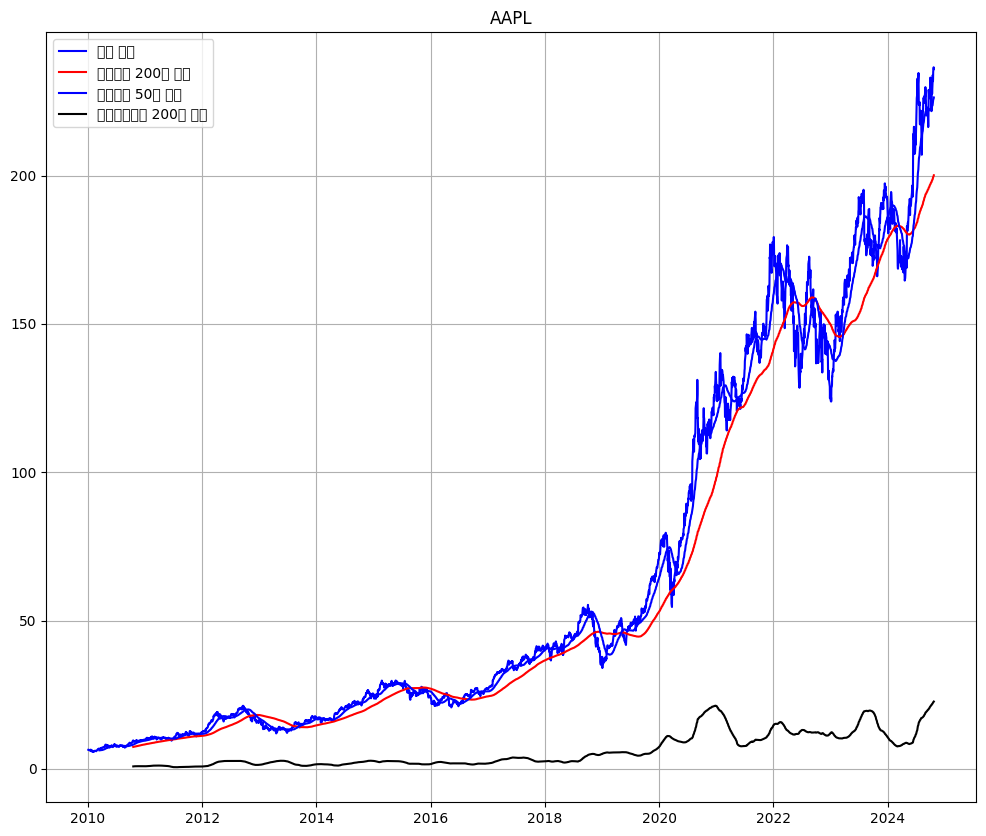

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(symbol_data, color='blue', label="실제 주가")
plt.plot(rolmean200, color='red',label=f"이동평균 {interval}일 기준")
plt.plot(rolmean50, color='blue', label=f"이동평균 {interval2}일 기준")
plt.plot(rolstd,color='black',label=f"이동표준편차 {interval}일 기준")
plt.title('AAPL')
plt.grid()
plt.legend()
plt.savefig(f"{symbol}_graph.png")
plt.show()

# ARIMA 모델

## 데이터 핸들링

In [ ]:
# 산업별 기준종가 데이터프레임 생성
sector_dataframes = {}
for column in sector_grouped_data.columns:
    sector_dataframes[column] = sector_grouped_data[[column]].rename(columns={column: 'Adj Close'})
sector = 'Consumer Cyclical'
sector_data = sector_dataframes[sector]

In [ ]:
# 사용할 데이터 설정(sector or symbol)
# data = symbol_data
arima_data = sector_data

## 정상성 검증

In [ ]:
def find_ARIMA_d(data, max_diff=5):
  for column in data.columns:
    diff_data = data[column]
    for d in range(1, max_diff+1):

      print(f"차분 {d}회차")
      diff_data = diff_data.diff().dropna()

      adf_result = adfuller(diff_data.values)
      adf_statistic = adf_result[0]
      adf_p_value = adf_result[1]

      statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')
      kpss_statistic = statistic
      kpss_p_value = p_value
      print("============================")
      print('ADF Statistics: %f' % adf_result[0])
      print('p-value: %f' % adf_result[1])
      print('\n')
      print(f'KPSS Statistic: {statistic}')
      print(f'p-value: {p_value}')
      print("============================")
      print('\n')

      if (adf_p_value <= 0.05 and adf_statistic < 0) and (kpss_p_value >= 0.05 and kpss_statistic <=0.5):
        print(f"적합한 차분횟수 {d}번")
        break
  return d

## 날짜기준으로 훈련,테스트 데이터 분할

In [ ]:
# 날짜 설정
# 훈련데이터 기간 :2014 ~ 2023
# 테스트데이터 기간 : 2024 ~
start_date = '2013-01-01'
end_date = '2023-12-31'
arima_train_data = arima_data[(arima_data.index >= start_date) & (arima_data.index <=end_date)]
arima_test_data = arima_data[arima_data.index > end_date]

## ARIMA 모수 결정

### ndiffs 함수를 이용해 차분 횟수 결정

In [ ]:
d = find_ARIMA_d(arima_train_data)

차분 1회차
ADF Statistics: -9.876595
p-value: 0.000000


KPSS Statistic: 0.11742972774458765
p-value: 0.1


적합한 차분횟수 1번


<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')


### auto_arima 함수를 이용해 ARIMA 모수 결정

In [ ]:
model_auto = pm.auto_arima(y=arima_train_data, d=d, start_p=0, max_p=3,start_q=0, max_q=3,m=1,seasonal=False,stepwise=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13116.866, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13118.853, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13118.854, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13119.797, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13120.365, Time=1.72 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.611 seconds


## ARIMA 모델 생성

In [ ]:
model = ARIMA(arima_train_data, order=model_auto.order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2768
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6558.899
Date:                Thu, 24 Oct 2024   AIC                          13119.797
Time:                        03:58:18   BIC                          13125.723
Sample:                             0   HQIC                         13121.937
                               - 2768                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.7054      0.072     93.505      0.000       6.565       6.846
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             13670.15
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              14.00   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 주가 예측

In [ ]:
forecast = model_fit.forecast(steps=len(arima_test_data))
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
2768,377.31347
2769,377.31347
2770,377.31347
2771,377.31347
2772,377.31347
...,...
2967,377.31347
2968,377.31347
2969,377.31347
2970,377.31347


## 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

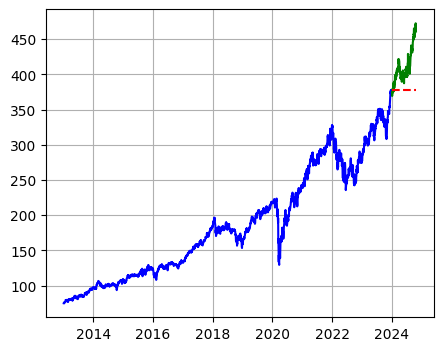

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(arima_train_data, label='Train Data', color='blue')
plt.plot(arima_test_data.index, arima_test_data, label='Test Data (Actual)', color='green')
plt.plot(arima_test_data.index, forecast, label='Forecasted Price', color='red', linestyle='--')
plt.grid()
plt.show

## 예측 결과 성능

In [ ]:
# 1. MAE (Mean Absolute Error)
print(sector,'예측 성능 평가')
mae = mean_absolute_error(arima_test_data, forecast)
print(f'MAE: {mae:.4f}')
# 2. MSE (Mean Squared Error)
mse = mean_squared_error(arima_test_data, forecast)
print(f'MSE: {mse:.4f}')
# 3. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.4f}')


Consumer Cyclical 예측 성능 평가
MAE: 34.8504
MSE: 1772.1169
RMSE: 42.0965


## 모든 산업별 예측, 그래프, 평가

In [ ]:
sectors = sector_grouped_data.columns.tolist()
sectors

['Basic Materials',
 'Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Industrials',
 'Real Estate',
 'Technology',
 'Utilities']


===== Basic Materials =====
차분 1회차
ADF Statistics: -14.863683
p-value: 0.000000


KPSS Statistic: 0.0941297741096379
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1118.066, Time=0.06 sec


<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1119.251, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1119.183, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1116.364, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1121.049, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.554 seconds

정확도 평가
MAE: 7.7918, MSE: 86.3348, RMSE: 9.2917



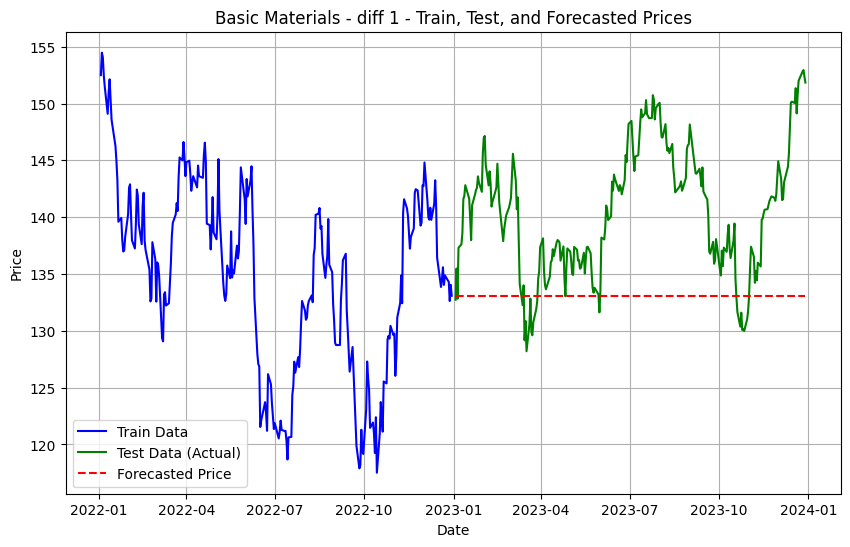

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Communication Services =====
차분 1회차
ADF Statistics: -15.301386
p-value: 0.000000


KPSS Statistic: 0.22403689927285647
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1050.442, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1052.265, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1052.265, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1051.973, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1054.266, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.457 seconds

정확도 평가
MAE: 18.8100, MSE: 419.0632, RMSE: 20.4710



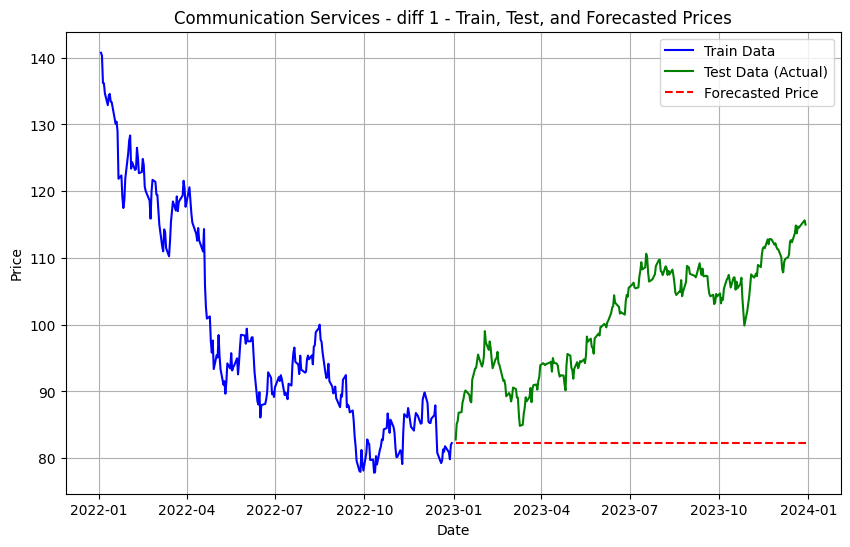

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Consumer Cyclical =====
차분 1회차
ADF Statistics: -15.644245
p-value: 0.000000


KPSS Statistic: 0.24352278656990559
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1483.270, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1485.264, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1485.263, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1481.675, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1484.851, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.733 seconds

정확도 평가
MAE: 49.3438, MSE: 2873.4673, RMSE: 53.6047



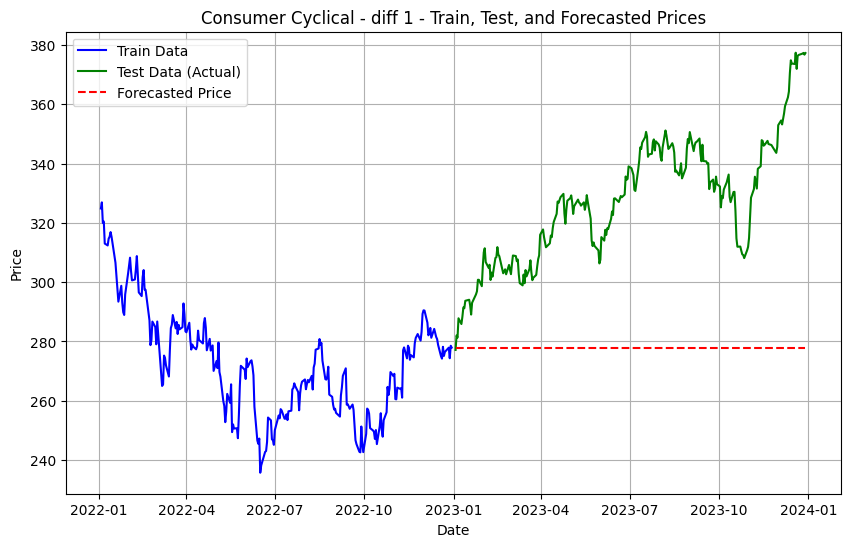

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Consumer Defensive =====
차분 1회차
ADF Statistics: -15.242093
p-value: 0.000000


KPSS Statistic: 0.050487038506706695
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=834.917, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=836.682, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=836.654, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=833.001, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=834.858, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds

정확도 평가
MAE: 4.0557, MSE: 32.3536, RMSE: 5.6880



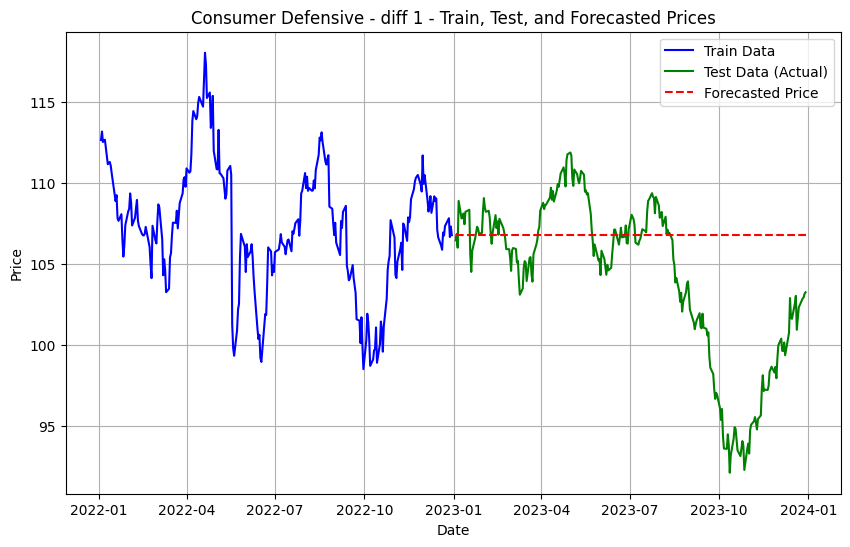

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Energy =====
차분 1회차
ADF Statistics: -15.649154
p-value: 0.000000


KPSS Statistic: 0.08322118299233289
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=943.457, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=945.446, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=945.446, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=942.618, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=947.455, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.340 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


정확도 평가
MAE: 3.8501, MSE: 20.6985, RMSE: 4.5496



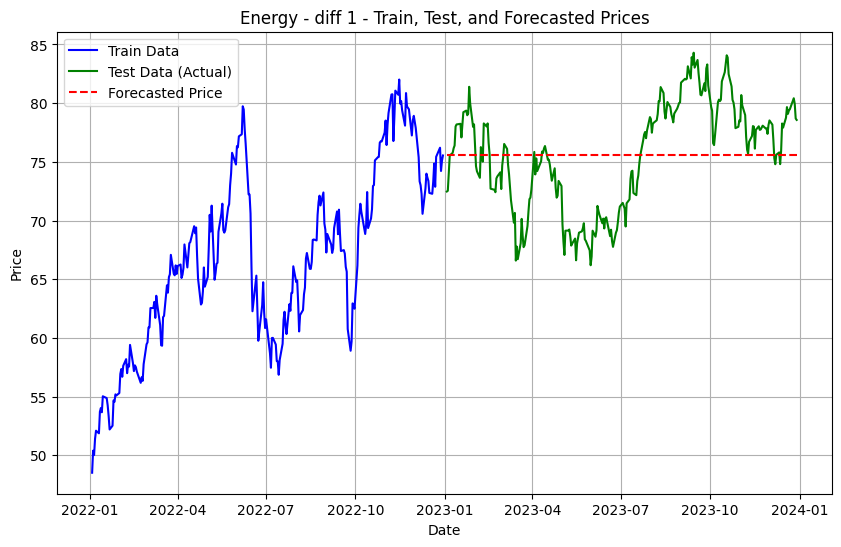

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Financial Services =====
차분 1회차
ADF Statistics: -15.265655
p-value: 0.000000


KPSS Statistic: 0.12958876409248554
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1081.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1083.302, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1083.274, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.787, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1083.234, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.471 seconds

정확도 평가
MAE: 6.4337, MSE: 70.4700, RMSE: 8.3946



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

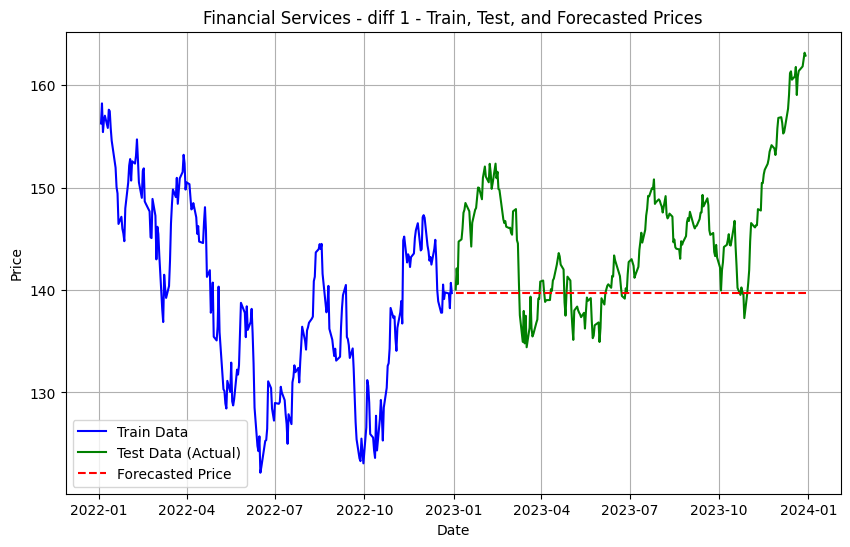

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Healthcare =====
차분 1회차
ADF Statistics: -14.609870
p-value: 0.000000


KPSS Statistic: 0.19062551071466513
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1275.303, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1275.836, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1275.677, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1273.549, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1277.536, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.613 seconds

정확도 평가
MAE: 5.2531, MSE: 42.7446, RMSE: 6.5379



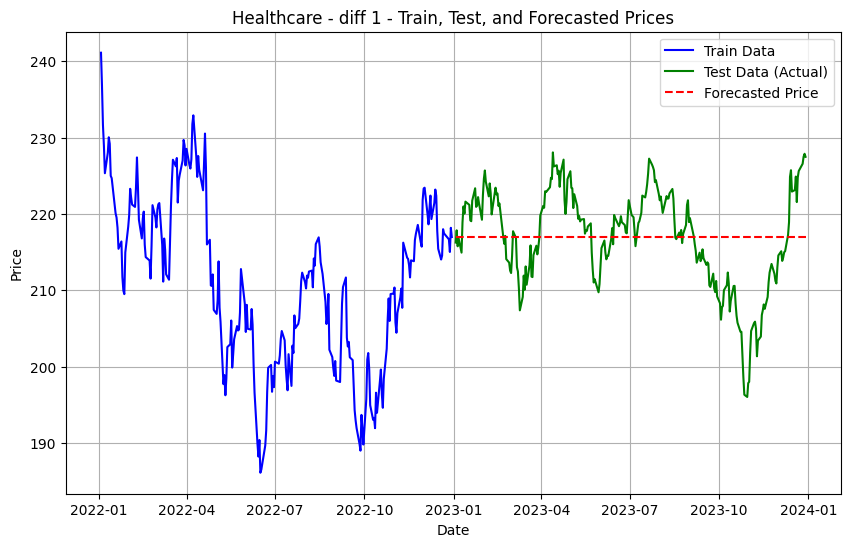

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Industrials =====
차분 1회차
ADF Statistics: -15.144141
p-value: 0.000000


KPSS Statistic: 0.13213254309122238
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1116.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1117.997, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1117.944, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1114.513, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1117.862, Time=2.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.295 seconds

정확도 평가
MAE: 15.2728, MSE: 324.0342, RMSE: 18.0009



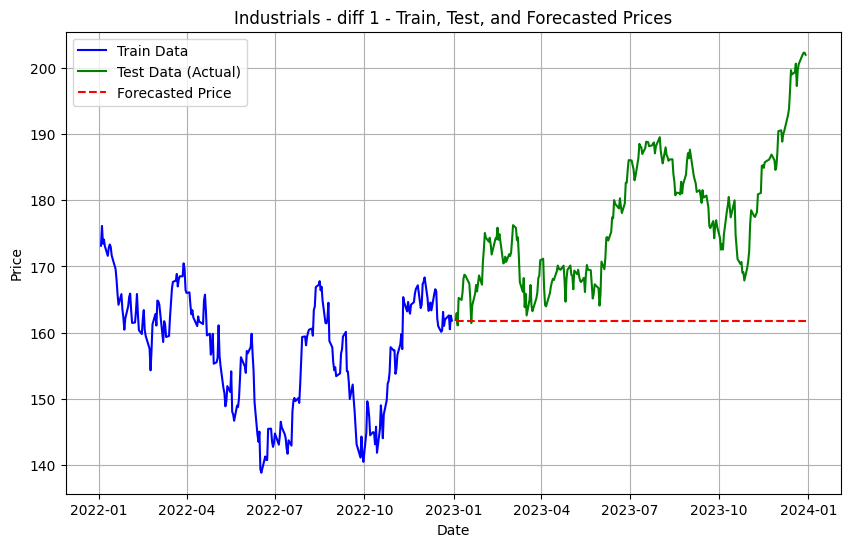

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Real Estate =====
차분 1회차
ADF Statistics: -14.632302
p-value: 0.000000


KPSS Statistic: 0.07648404843813335
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1079.355, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1080.096, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1079.893, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.019, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1076.578, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1078.570, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1078.570, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1080.259, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1080.932, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1080.578, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1076.109, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1079.322, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1079.975, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 3.953 seconds

정확도 평가
MAE: 4.6011, MSE: 33.7623, RMSE: 5.8105



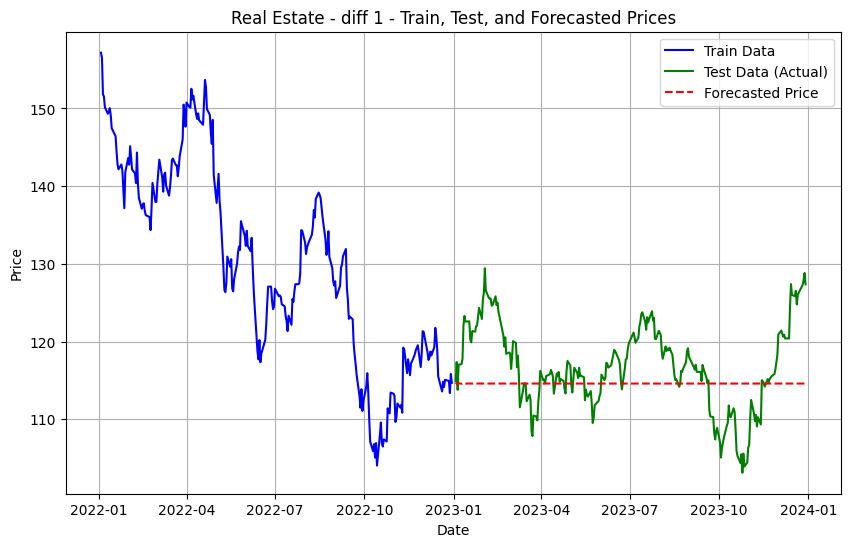

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Technology =====
차분 1회차
ADF Statistics: -15.443924
p-value: 0.000000


KPSS Statistic: 0.14901953218862846
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1307.537, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1309.456, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1309.451, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1306.398, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.444 seconds

정확도 평가
MAE: 25.2853, MSE: 818.7545, RMSE: 28.6139



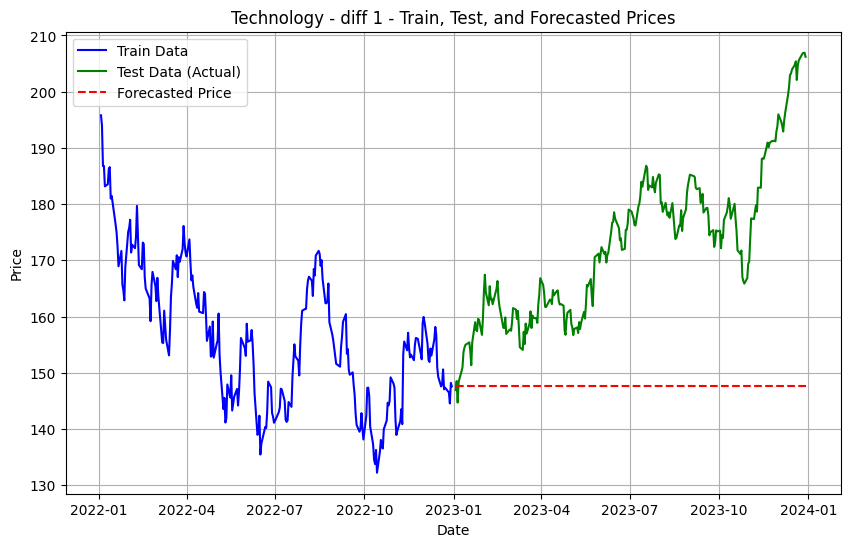

<ipython-input-21-a06b3959a743>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags , critical_values = kpss(diff_data.values,regression='c')



===== Utilities =====
차분 1회차
ADF Statistics: -7.753619
p-value: 0.000000


KPSS Statistic: 0.04954319981581387
p-value: 0.1


적합한 차분횟수 1번
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=632.729, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=634.649, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=634.649, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.749, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=636.649, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.612 seconds

정확도 평가
MAE: 2.8762, MSE: 12.3665, RMSE: 3.5166



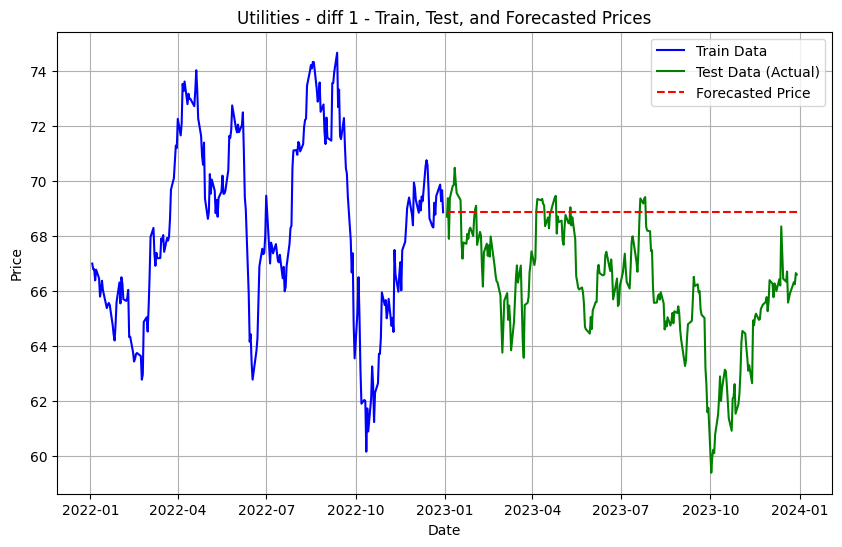

전체 섹터의 RMSE 평균: 14.9527


In [ ]:
performance_metrics = {}
start_date = '2022-01-01'
end_date = '2022-12-31'
test_end_date = '2023-12-31'

# 각 섹터별로 ARIMA 모델 적용
for sector in sectors:
    print(f"\n===== {sector} =====")
    data = sector_grouped_data[sector]
    arima_train_data = pd.DataFrame(data[(data.index >= start_date) & (data.index <=end_date)])
    arima_test_data = pd.DataFrame(data[(data.index > end_date) & (data.index <= test_end_date)])

    find_d = find_ARIMA_d(arima_train_data, max_diff=5)
    model_auto = pm.auto_arima(y=arima_train_data, d=find_d, start_p=0, max_p=3,start_q=0, max_q=3,m=1,seasonal=False,stepwise=True,trace=True)

    model = ARIMA(arima_train_data, order=model_auto.order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(arima_test_data))

    # 성능 평가 (MAE, MSE, RMSE, MAPE)
    mae = mean_absolute_error(arima_test_data, forecast)
    mse = mean_squared_error(arima_test_data, forecast)
    rmse = np.sqrt(mse)

    performance_metrics[sector] = {
        'RMSE': rmse,
    }
    print('\n정확도 평가')
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}\n')

    plt.figure(figsize=(10, 6))
    plt.plot(arima_train_data, label='Train Data', color='blue')
    plt.plot(arima_test_data.index, arima_test_data, label='Test Data (Actual)', color='green')

    # 예측값
    plt.plot(arima_test_data.index, forecast, label='Forecasted Price', color='red', linestyle='--')

    # 그래프 설정
    plt.title(f'{sector} - diff {find_d} - Train, Test, and Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'diff-{find_d} {sector} graph.png')
    plt.show()

rmse_list = []
for sector, metrics in performance_metrics.items():
    rmse_list.append(metrics['RMSE'])
avg_rmse = np.mean(rmse_list)
print(f"전체 섹터의 RMSE 평균: {avg_rmse:.4f}")

### 차분 1, 2 2022학습 1년예측 그래프, 평가


===== Basic Materials =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1118.066, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1119.251, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1119.183, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1116.364, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1121.049, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1272.052, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1218.392, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1270.055, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1193.912, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1177.252, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1175.254, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1191.914, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.489 seconds

Basic Materials - 차분 1 정확도 평가: MAE: 7.7918, MSE: 86.3348, RMSE: 9.2917
Basic Materials - 차분 2 정확도 평가: MAE: 57.0616, MSE: 4174.3754, RMSE: 64.6094



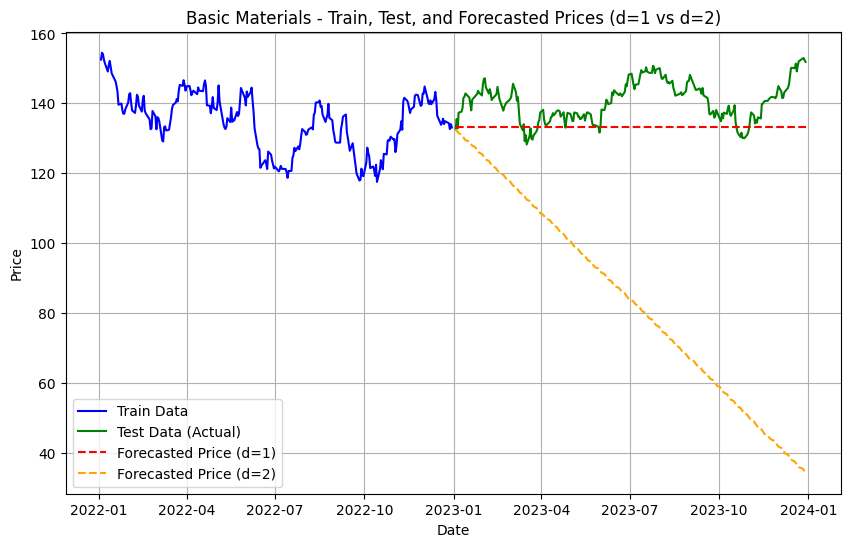


===== Communication Services =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1050.442, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1052.265, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1052.265, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1051.973, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1054.266, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.232 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1213.088, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1147.137, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1211.088, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1120.076, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1113.215, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1111.234, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1118.092, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.412 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Communication Services - 차분 1 정확도 평가: MAE: 18.8100, MSE: 419.0632, RMSE: 20.4710
Communication Services - 차분 2 정확도 평가: MAE: 43.3983, MSE: 2640.2811, RMSE: 51.3837



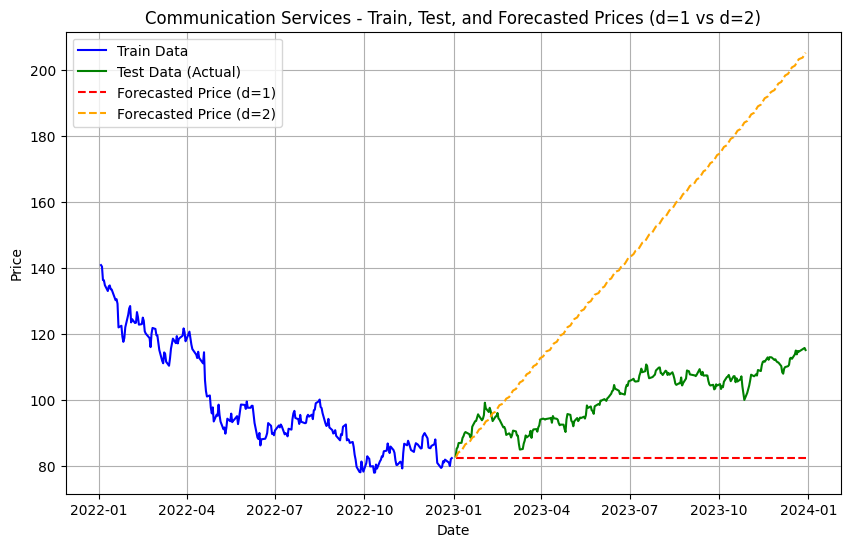


===== Consumer Cyclical =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1483.270, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1485.264, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1485.263, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1481.675, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1484.851, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.682 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1649.565, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1588.958, Time=0.09 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1647.565, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1567.703, Time=0.61 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1547.070, Time=0.34 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1545.074, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1565.705, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 6.070 seconds

Consumer Cyclical - 차분 1 정확도 평가: MAE: 49.3438, MSE: 2873.4673, RMSE: 53.6047
Consumer Cyclical - 차분 2 정확도 평가: MAE: 14.1084, MSE: 351.9484, RMSE: 18.7603



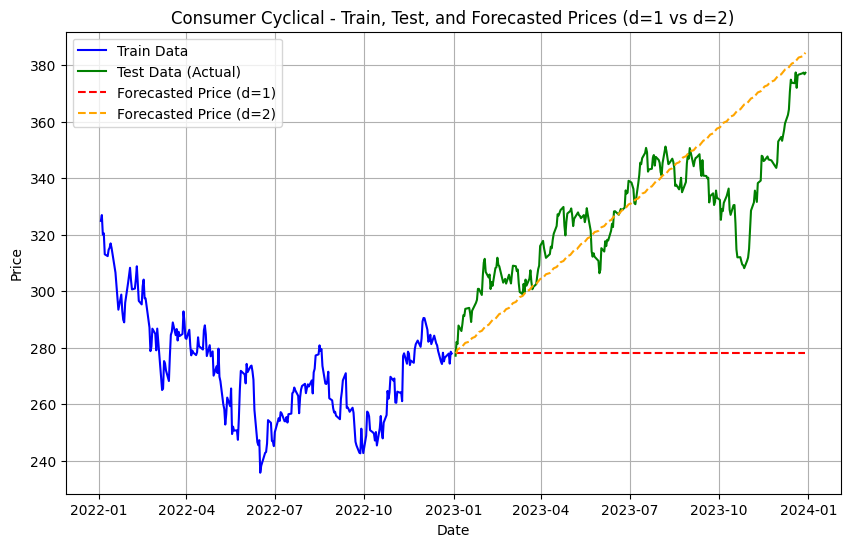


===== Consumer Defensive =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=834.917, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=836.682, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=836.654, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=833.001, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=834.858, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.730 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=997.257, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=941.485, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=995.259, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=912.634, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=900.779, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=898.780, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=910.635, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.604 seconds

Consumer Defensive - 차분 1 정확도 평가: MAE: 4.0557, MSE: 32.3536, RMSE: 5.6880
Consumer Defensive - 차분 2 정확도 평가: MAE: 25.0388, MSE: 792.9857, RMSE: 28.1600



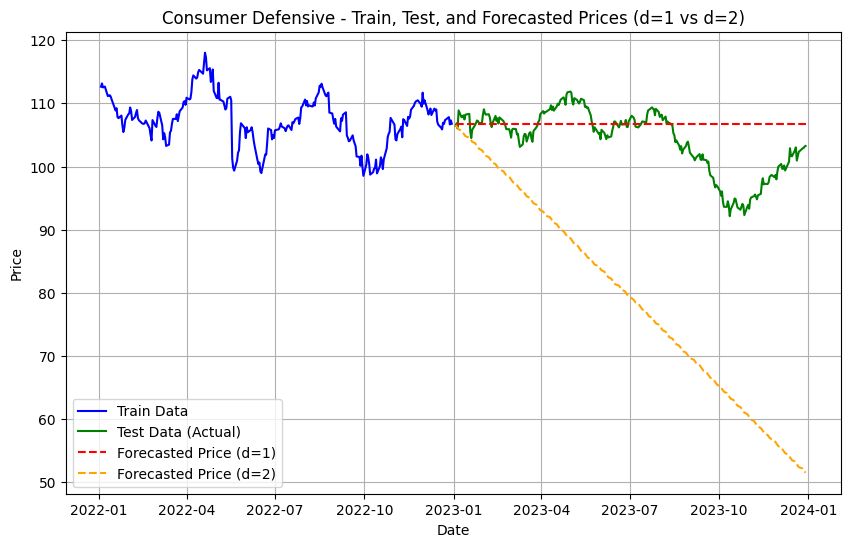


===== Energy =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=943.457, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=945.446, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=945.446, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=942.618, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=947.455, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.500 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1110.966, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1040.409, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1108.968, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1016.307, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=997.230, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=995.236, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1014.311, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.801 seconds

Energy - 차분 1 정확도 평가: MAE: 3.8501, MSE: 20.6985, RMSE: 4.5496
Energy - 차분 2 정확도 평가: MAE: 15.9986, MSE: 317.1121, RMSE: 17.8076



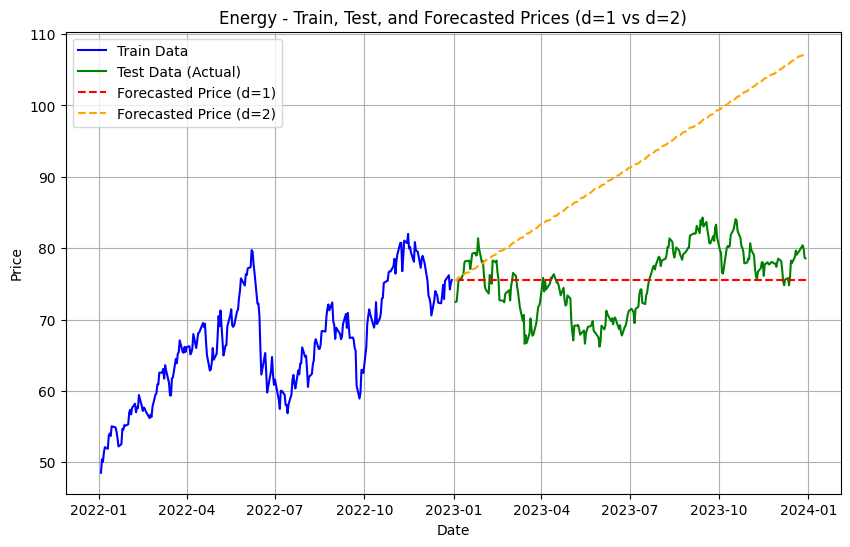


===== Financial Services =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1081.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1083.302, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1083.274, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.787, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1083.234, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.128 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1242.503, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1186.757, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1240.507, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1152.105, Time=0.63 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1136.711, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1134.712, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1150.106, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 4.935 seconds

Financial Services - 차분 1 정확도 평가: MAE: 6.4337, MSE: 70.4700, RMSE: 8.3946
Financial Services - 차분 2 정확도 평가: MAE: 6.6961, MSE: 75.6238, RMSE: 8.6962



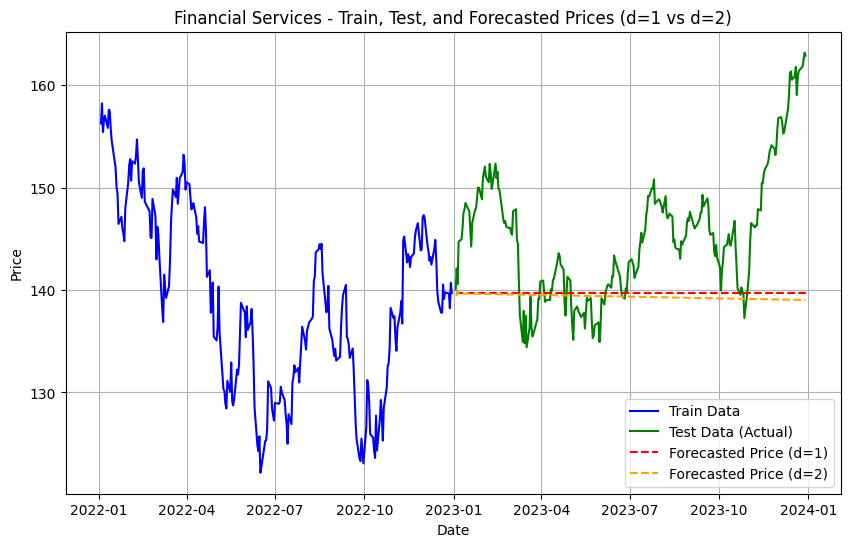


===== Healthcare =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1275.303, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1275.836, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1275.677, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1273.549, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1277.536, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.692 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1422.953, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1373.477, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1420.955, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1352.717, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1333.607, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1331.640, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1350.737, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.457 seconds

Healthcare - 차분 1 정확도 평가: MAE: 5.2531, MSE: 42.7446, RMSE: 6.5379
Healthcare - 차분 2 정확도 평가: MAE: 6.5010, MSE: 63.4410, RMSE: 7.9650



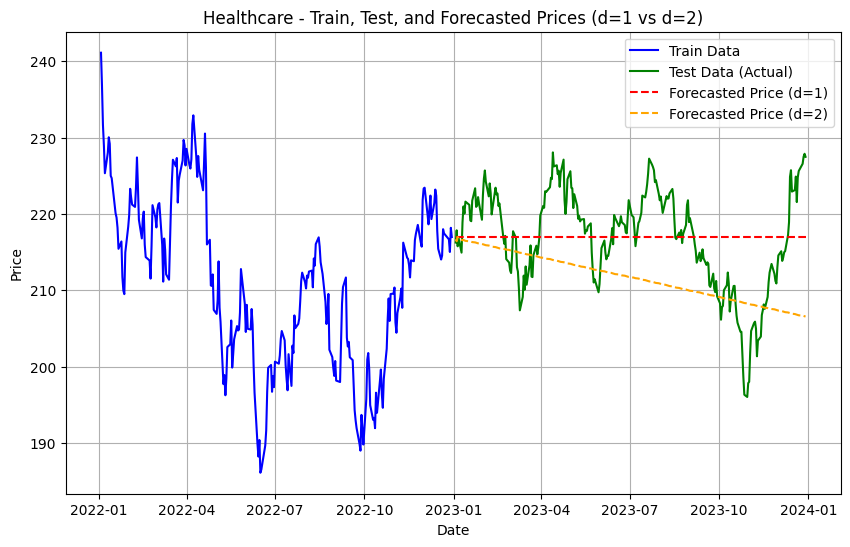


===== Industrials =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1116.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1117.997, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1117.944, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1114.513, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1117.862, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.774 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1274.232, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1220.910, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1272.238, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1192.008, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1177.346, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1175.348, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1190.010, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=1.85 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 4.981 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Industrials - 차분 1 정확도 평가: MAE: 15.2728, MSE: 324.0342, RMSE: 18.0009
Industrials - 차분 2 정확도 평가: MAE: 26.0226, MSE: 890.5778, RMSE: 29.8426



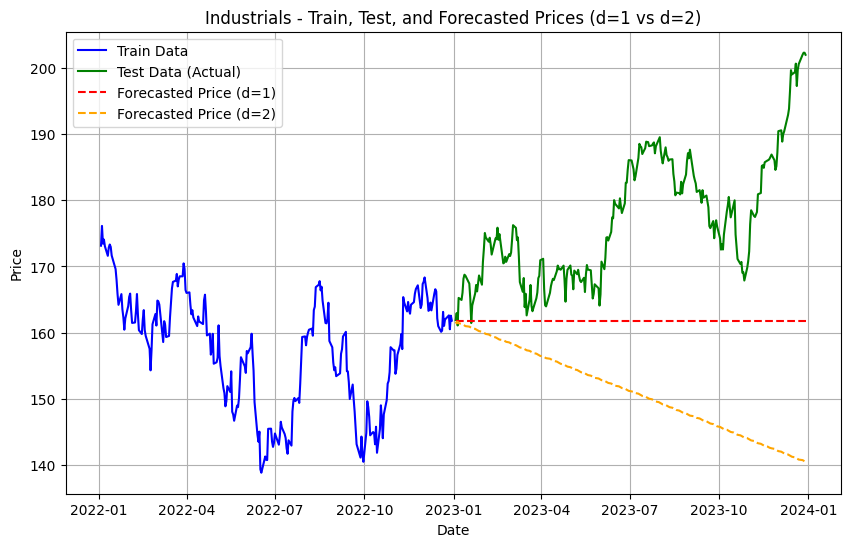


===== Real Estate =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1079.355, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1080.096, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1079.893, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.019, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1076.578, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1078.570, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1078.570, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1080.259, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1080.932, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1080.578, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1076.109, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1079.322, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1079.541, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1078.109, Time=0.18 sec
 ARIMA(1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1181.200, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1228.171, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1143.501, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1138.213, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1136.224, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1141.509, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.708 seconds

Real Estate - 차분 1 정확도 평가: MAE: 4.6011, MSE: 33.7623, RMSE: 5.8105
Real Estate - 차분 2 정확도 평가: MAE: 18.0018, MSE: 417.2284, RMSE: 20.4262



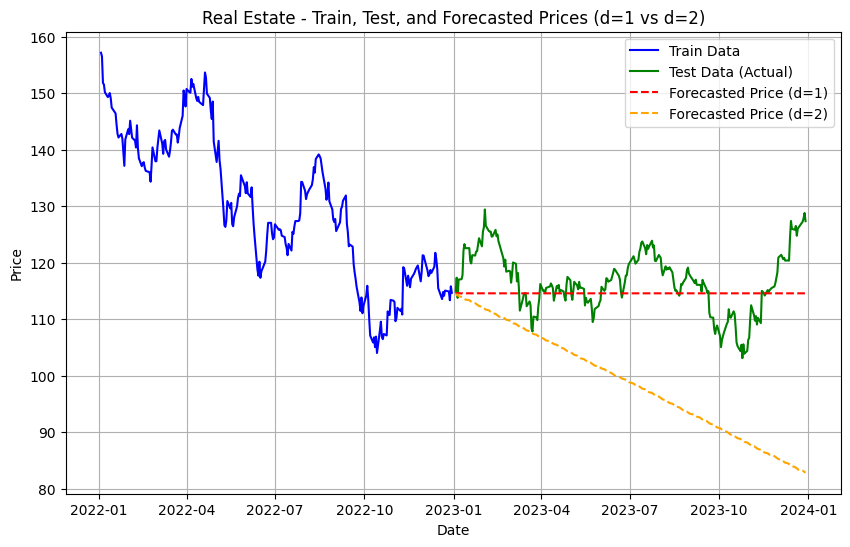


===== Technology =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1307.537, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1309.456, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1309.451, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1306.398, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.428 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1471.279, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1408.835, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1469.280, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1386.330, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1372.735, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1370.757, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1384.345, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 7.180 seconds

Technology - 차분 1 정확도 평가: MAE: 25.2853, MSE: 818.7545, RMSE: 28.6139
Technology - 차분 2 정확도 평가: MAE: 19.2139, MSE: 543.3298, RMSE: 23.3094



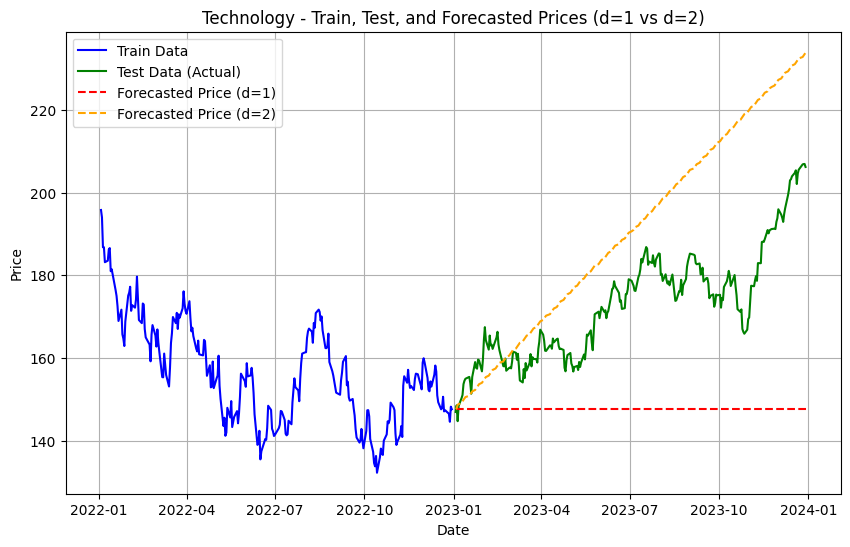


===== Utilities =====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=632.729, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=634.649, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=634.649, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.749, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=636.649, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.394 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=798.798, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=731.975, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=796.799, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=685.848, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=672.198, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=670.198, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=683.849, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.990 seconds

Utilities - 차분 1 정확도 평가: MAE: 2.8762, MSE: 12.3665, RMSE: 3.5166
Utilities - 차분 2 정확도 평가: MAE: 32.0798, MSE: 1390.0367, RMSE: 37.2832



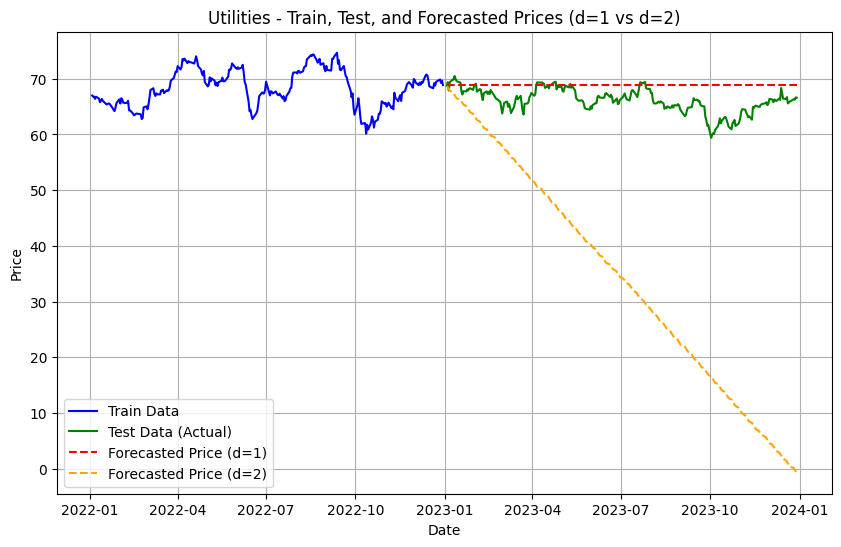

전체 섹터의 RMSE 평균 (차분 1): 14.9527
전체 섹터의 RMSE 평균 (차분 2): 28.0221


In [ ]:
performance_metrics_d1 = {}
performance_metrics_d2 = {}

start_date = '2022-01-01'
end_date = '2022-12-31'
test_end_date = '2023-12-31'

# 각 섹터별로 ARIMA 모델 적용
for sector in sectors:
    print(f"\n===== {sector} =====")
    data = sector_grouped_data[sector]
    arima_train_data = pd.DataFrame(data[(data.index >= start_date) & (data.index <=end_date)])

    arima_test_data = pd.DataFrame(data[(data.index > end_date) & (data.index <= test_end_date)])

    # 차분 1 모델 학습
    model_auto_d1 = pm.auto_arima(y=arima_train_data, d=1, start_p=0, max_p=3, start_q=0, max_q=3, m=1, seasonal=False, stepwise=True, trace=True)
    model_d1 = ARIMA(arima_train_data, order=model_auto_d1.order)
    model_fit_d1 = model_d1.fit()
    forecast_d1 = model_fit_d1.forecast(steps=len(arima_test_data))

    # 차분 2 모델 학습
    model_auto_d2 = pm.auto_arima(y=arima_train_data, d=2, start_p=0, max_p=3, start_q=0, max_q=3, m=1, seasonal=False, stepwise=True, trace=True)
    model_d2 = ARIMA(arima_train_data, order=model_auto_d2.order)
    model_fit_d2 = model_d2.fit()
    forecast_d2 = model_fit_d2.forecast(steps=len(arima_test_data))

    # 성능 평가 (MAE, MSE, RMSE)
    mae_d1 = mean_absolute_error(arima_test_data, forecast_d1)
    mse_d1 = mean_squared_error(arima_test_data, forecast_d1)
    rmse_d1 = np.sqrt(mse_d1)

    mae_d2 = mean_absolute_error(arima_test_data, forecast_d2)
    mse_d2 = mean_squared_error(arima_test_data, forecast_d2)
    rmse_d2 = np.sqrt(mse_d2)

    performance_metrics_d1[sector] = {
        'RMSE': rmse_d1,
    }

    performance_metrics_d2[sector] = {
        'RMSE': rmse_d2,
    }

    # 성능 출력
    print(f'\n{sector} - 차분 1 정확도 평가: MAE: {mae_d1:.4f}, MSE: {mse_d1:.4f}, RMSE: {rmse_d1:.4f}')
    print(f'{sector} - 차분 2 정확도 평가: MAE: {mae_d2:.4f}, MSE: {mse_d2:.4f}, RMSE: {rmse_d2:.4f}\n')

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(arima_train_data, label='Train Data', color='blue')
    plt.plot(arima_test_data.index, arima_test_data, label='Test Data (Actual)', color='green')

    # 차분 1 예측값
    plt.plot(arima_test_data.index, forecast_d1, label='Forecasted Price (d=1)', color='red', linestyle='--')

    # 차분 2 예측값
    plt.plot(arima_test_data.index, forecast_d2, label='Forecasted Price (d=2)', color='orange', linestyle='--')

    # 그래프 설정
    plt.title(f'{sector} - Train, Test, and Forecasted Prices (d=1 vs d=2)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'd-{sector}-comparison-graph.png')
    plt.show()

# RMSE 평균 계산
rmse_list_d1 = []
rmse_list_d2 = []
for sector in sectors:
    rmse_list_d1.append(performance_metrics_d1[sector]['RMSE'])
    rmse_list_d2.append(performance_metrics_d2[sector]['RMSE'])

avg_rmse_d1 = np.mean(rmse_list_d1)
avg_rmse_d2 = np.mean(rmse_list_d2)

print(f"전체 섹터의 RMSE 평균 (차분 1): {avg_rmse_d1:.4f}")
print(f"전체 섹터의 RMSE 평균 (차분 2): {avg_rmse_d2:.4f}")

### 차분2, 2022학습 2023 5일 10일 예측


===== Basic Materials =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1272.052, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1218.392, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1270.055, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1193.912, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1177.252, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1175.254, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1191.914, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 6.615 seconds

정확도 평가 (5일 예측)
RMSE (5일): 4.2622

정확도 평가 (10일 예측)
RMSE (10일): 8.7473



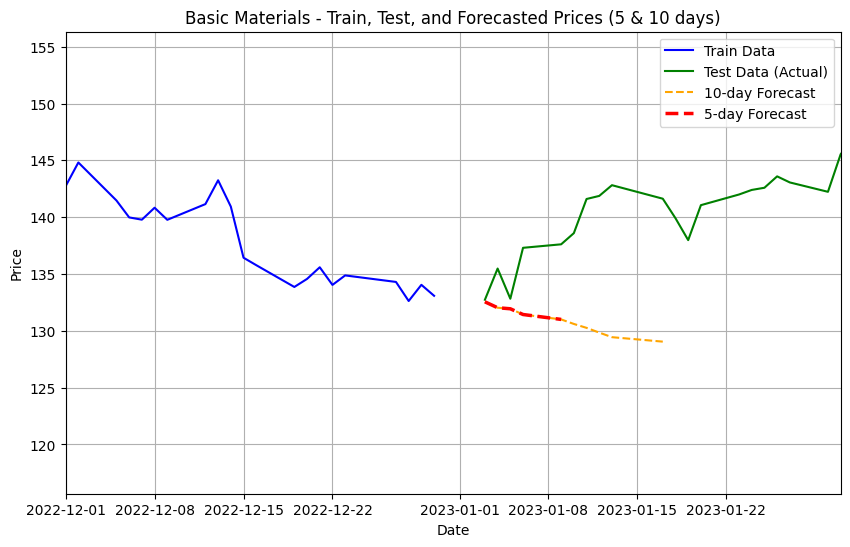


===== Communication Services =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1213.088, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1147.137, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1211.088, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1120.076, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1113.215, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1111.234, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1118.092, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.362 seconds

정확도 평가 (5일 예측)
RMSE (5일): 2.0969

정확도 평가 (10일 예측)
RMSE (10일): 2.8005



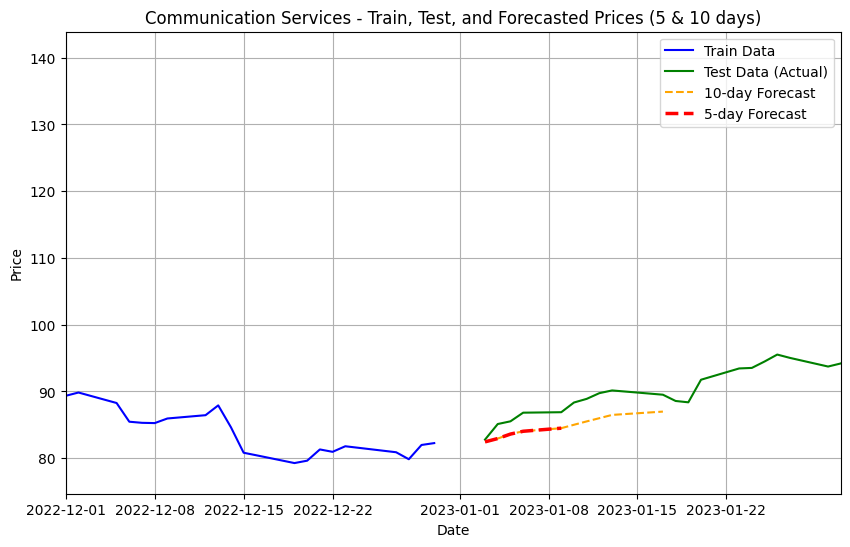


===== Consumer Cyclical =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1649.565, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1588.958, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1647.565, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1567.703, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1547.070, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1545.074, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1565.705, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 2.437 seconds

정확도 평가 (5일 예측)
RMSE (5일): 4.9556

정확도 평가 (10일 예측)
RMSE (10일): 8.2889



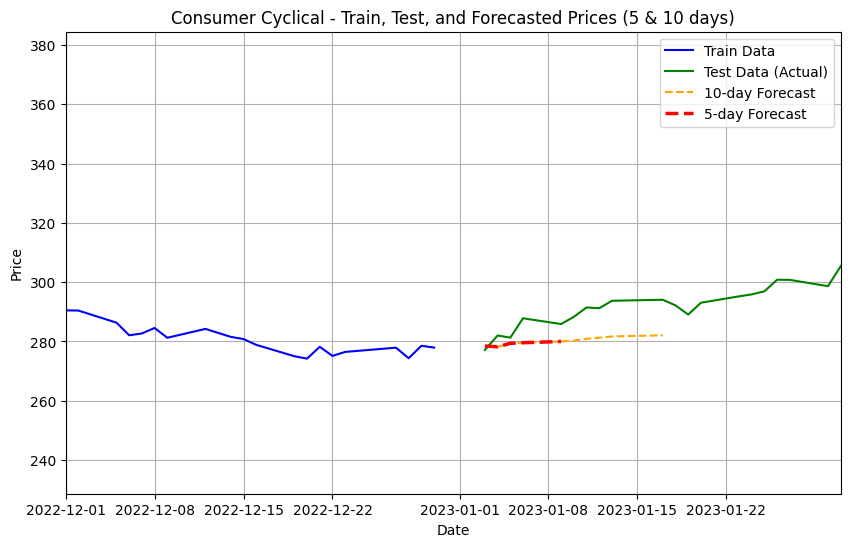


===== Consumer Defensive =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=997.257, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=941.485, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=995.259, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=912.634, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=900.779, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=898.780, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=910.635, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=1.83 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 6.189 seconds

정확도 평가 (5일 예측)
RMSE (5일): 1.6628

정확도 평가 (10일 예측)
RMSE (10일): 2.4396



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

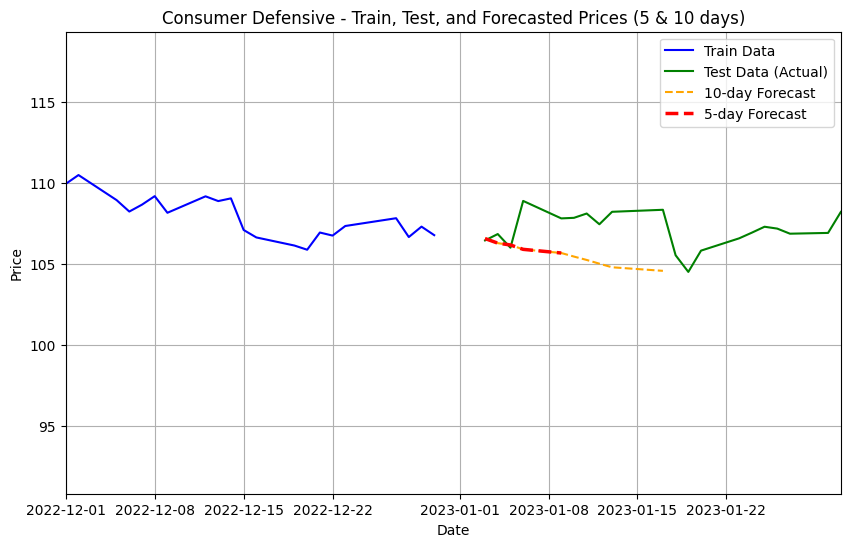


===== Energy =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1110.966, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1040.409, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1108.968, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1016.307, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=997.230, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=995.236, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1014.311, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.811 seconds

정확도 평가 (5일 예측)
RMSE (5일): 2.0778

정확도 평가 (10일 예측)
RMSE (10일): 1.7211



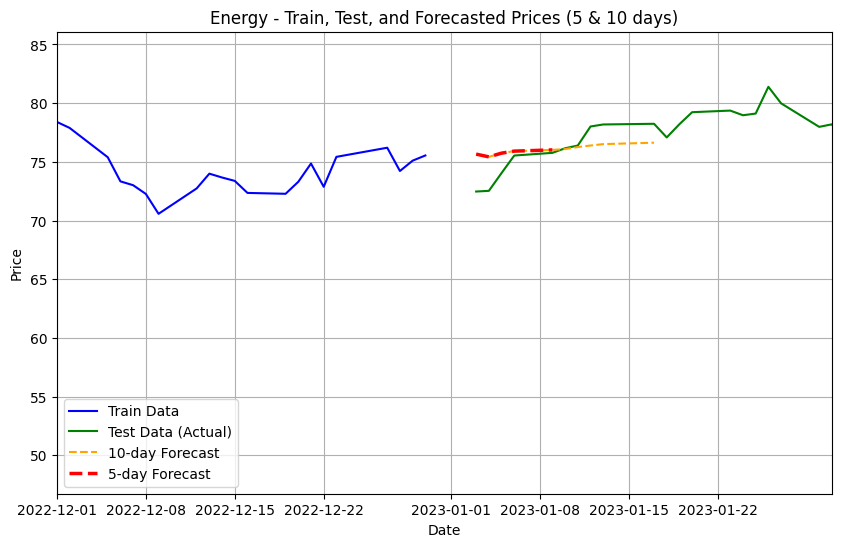


===== Financial Services =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1242.503, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1186.757, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1240.507, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1152.105, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1136.711, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1134.712, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1150.106, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.055 seconds

정확도 평가 (5일 예측)
RMSE (5일): 3.5254

정확도 평가 (10일 예측)
RMSE (10일): 6.1217



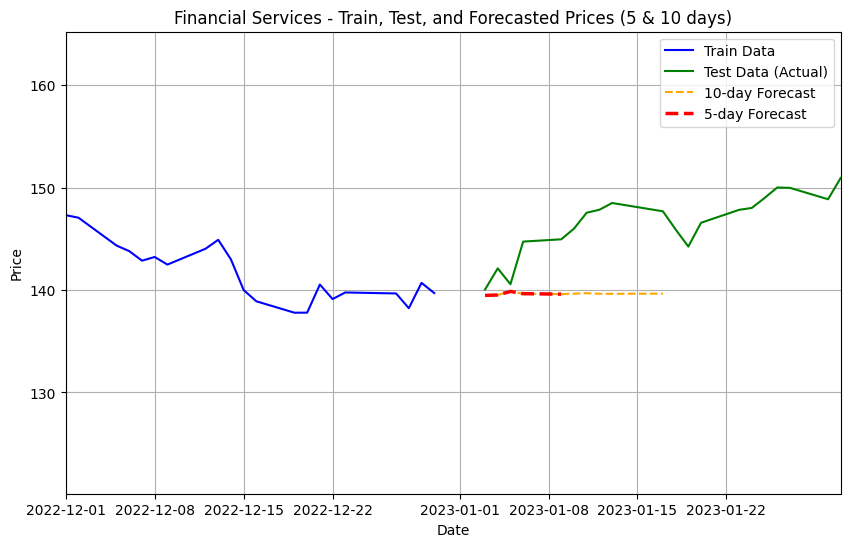


===== Healthcare =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1422.953, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1373.477, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1420.955, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1352.717, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1333.607, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1331.640, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1350.737, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=2.26 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 6.612 seconds

정확도 평가 (5일 예측)
RMSE (5일): 1.1398

정확도 평가 (10일 예측)
RMSE (10일): 3.0434



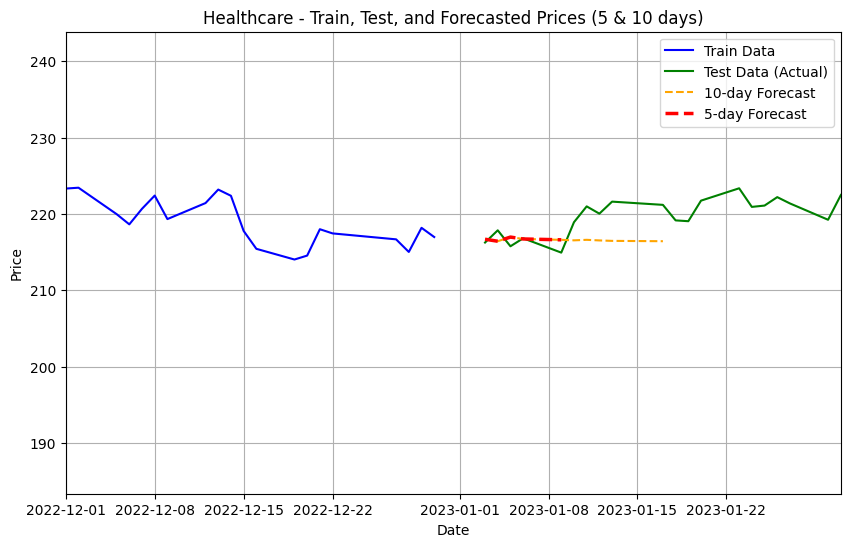


===== Industrials =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1274.232, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1220.910, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1272.238, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1192.008, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1177.346, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1175.348, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1190.010, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.035 seconds

정확도 평가 (5일 예측)
RMSE (5일): 2.4742

정확도 평가 (10일 예측)
RMSE (10일): 5.1194



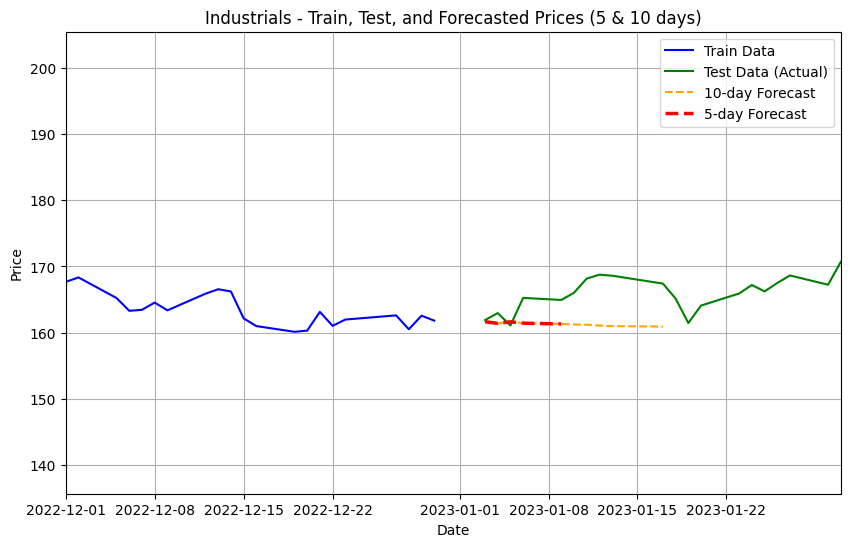


===== Real Estate =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1230.171, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1181.200, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1228.171, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1143.501, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1138.213, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1136.224, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1141.509, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.294 seconds

정확도 평가 (5일 예측)
RMSE (5일): 2.3753

정확도 평가 (10일 예측)
RMSE (10일): 6.1225



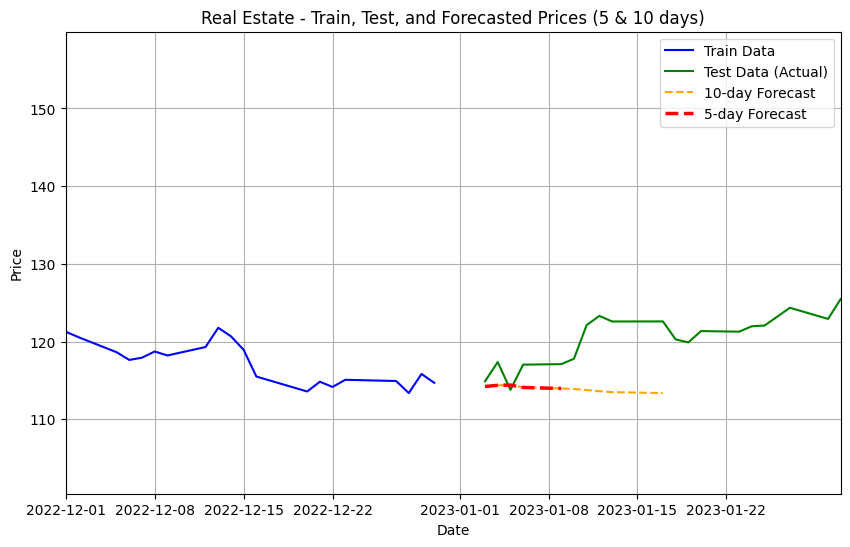


===== Technology =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1471.279, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1408.835, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1469.280, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1386.330, Time=0.36 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1372.735, Time=0.34 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1370.757, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1384.345, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 7.489 seconds

정확도 평가 (5일 예측)
RMSE (5일): 1.9098

정확도 평가 (10일 예측)
RMSE (10일): 3.0626



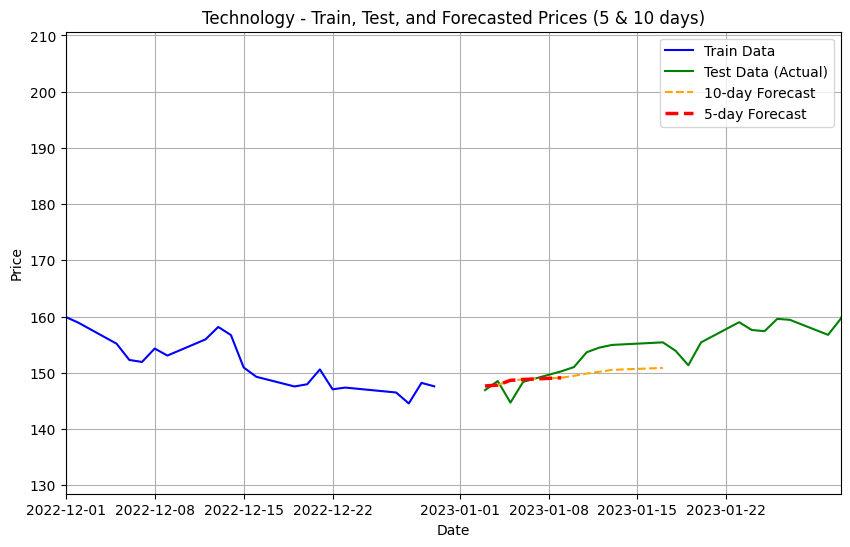


===== Utilities =====
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=798.798, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=731.975, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=796.799, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=685.848, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=672.198, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=670.198, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=683.849, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.714 seconds

정확도 평가 (5일 예측)
RMSE (5일): 1.2798

정확도 평가 (10일 예측)
RMSE (10일): 2.3535



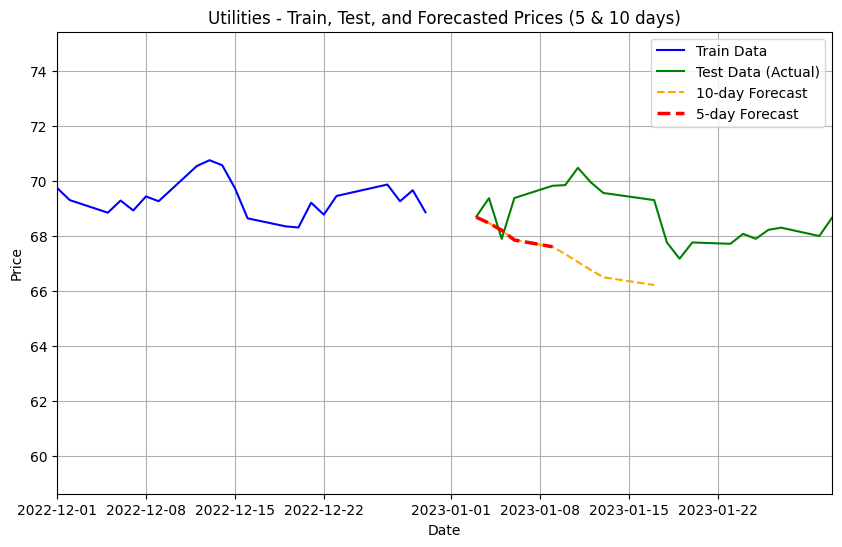

섹터: Basic Materials, 5일 예측 RMSE: 4.2622, 10일 예측 RMSE: 8.7473
섹터: Communication Services, 5일 예측 RMSE: 2.0969, 10일 예측 RMSE: 2.8005
섹터: Consumer Cyclical, 5일 예측 RMSE: 4.9556, 10일 예측 RMSE: 8.2889
섹터: Consumer Defensive, 5일 예측 RMSE: 1.6628, 10일 예측 RMSE: 2.4396
섹터: Energy, 5일 예측 RMSE: 2.0778, 10일 예측 RMSE: 1.7211
섹터: Financial Services, 5일 예측 RMSE: 3.5254, 10일 예측 RMSE: 6.1217
섹터: Healthcare, 5일 예측 RMSE: 1.1398, 10일 예측 RMSE: 3.0434
섹터: Industrials, 5일 예측 RMSE: 2.4742, 10일 예측 RMSE: 5.1194
섹터: Real Estate, 5일 예측 RMSE: 2.3753, 10일 예측 RMSE: 6.1225
섹터: Technology, 5일 예측 RMSE: 1.9098, 10일 예측 RMSE: 3.0626
섹터: Utilities, 5일 예측 RMSE: 1.2798, 10일 예측 RMSE: 2.3535


In [ ]:
performance_metrics = {}
start_date = '2022-01-01'
test_start_date = '2022-12-31'
test_end_date = '2023-12-31'  # 2024년 10월 전체를 테스트 데이터로 사용

rmse_comparison = {}

# 각 섹터별로 ARIMA 모델 적용
for sector in sectors:
    print(f"\n===== {sector} =====")
    data = sector_grouped_data[sector]
    arima_train_data = pd.DataFrame(data[(data.index >= start_date) & (data.index < test_start_date)])
    arima_test_data = pd.DataFrame(data[(data.index >= test_start_date) & (data.index <= test_end_date)])

    find_d = 2
    model_auto = pm.auto_arima(y=arima_train_data, d=find_d, start_p=0, max_p=3, start_q=0, max_q=3, m=1, seasonal=False, stepwise=True, trace=True)

    model = ARIMA(arima_train_data, order=model_auto.order)
    model_fit = model.fit()

    # 5일, 10일 예측
    forecast_5d = model_fit.forecast(steps=5)
    forecast_10d = model_fit.forecast(steps=10)

    # 성능 평가 (5일 예측)
    mae_5d = mean_absolute_error(arima_test_data.iloc[:5], forecast_5d)
    mse_5d = mean_squared_error(arima_test_data.iloc[:5], forecast_5d)
    rmse_5d = np.sqrt(mse_5d)

    # 성능 평가 (10일 예측)
    mae_10d = mean_absolute_error(arima_test_data.iloc[:10], forecast_10d)
    mse_10d = mean_squared_error(arima_test_data.iloc[:10], forecast_10d)
    rmse_10d = np.sqrt(mse_10d)

    performance_metrics[sector] = {
        '5D_RMSE': rmse_5d,
        '10D_RMSE': rmse_10d,
    }

    print('\n정확도 평가 (5일 예측)')
    print(f'RMSE (5일): {rmse_5d:.4f}')

    print('\n정확도 평가 (10일 예측)')
    print(f'RMSE (10일): {rmse_10d:.4f}\n')

    # 그래프 설정 (훈련 데이터, 실제 데이터, 5일/10일 예측 비교)
    plt.figure(figsize=(10, 6))

    # 훈련 데이터
    plt.plot(arima_train_data.index, arima_train_data, label='Train Data', color='blue')

    # 테스트 데이터 (실제)
    plt.plot(arima_test_data.index, arima_test_data, label='Test Data (Actual)', color='green')

    # 10일 예측
    plt.plot(arima_test_data.index[:10], forecast_10d, label='10-day Forecast', color='orange', linestyle='--')

    # 5일 예측
    plt.plot(arima_test_data.index[:5], forecast_5d, label='5-day Forecast', color='red', linestyle='--', linewidth=2.5, zorder=4)


    # 최근 2개월 범위로 그래프 제한
    plt.xlim(pd.Timestamp('2022-12-01'), pd.Timestamp('2023-01-31'))

    # 그래프 설정
    plt.title(f'{sector} - Train, Test, and Forecasted Prices (5 & 10 days)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# RMSE 비교 출력
for sector, metrics in performance_metrics.items():
    print(f"섹터: {sector}, 5일 예측 RMSE: {metrics['5D_RMSE']:.4f}, 10일 예측 RMSE: {metrics['10D_RMSE']:.4f}")

### 산업별 성능 평가 비교

In [ ]:
rmse_5d_list = []
rmse_10d_list = []

# 각 섹터의 RMSE 값을 리스트에 저장
for sector, metrics in performance_metrics.items():
    rmse_5d_list.append(metrics['5D_RMSE'])
    rmse_10d_list.append(metrics['10D_RMSE'])

# 5D_RMSE와 10D_RMSE의 평균 계산
average_5d_rmse = np.mean(rmse_5d_list)
average_10d_rmse = np.mean(rmse_10d_list)

# 결과 출력
print(f"전체 섹터의 5D_RMSE 평균: {average_5d_rmse:.4f}")
print(f"전체 섹터의 10D_RMSE 평균: {average_10d_rmse:.4f}")

전체 섹터의 5D_RMSE 평균: 2.5236
전체 섹터의 10D_RMSE 평균: 4.5291


# VAR(백터자기회귀) 모델

## 데이터 핸들링

In [ ]:
# 산업별 평균주가 데이터
grouped_by_sector =  merged_df.groupby(['Date', 'Sector'])[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].mean()
grouped_by_sector['Volume'] = grouped_by_sector['Volume'] / 1_000_000
sector_dfs = {sector: grouped_by_sector.xs(sector, level='Sector') for sector in grouped_by_sector.index.get_level_values('Sector').unique()}
sector_dfs['Basic Materials']

In [ ]:
for sector, df in sector_dfs.items():

    # VAR 모델 학습
    model = VAR(df)
    results = model.fit(maxlags=5, ic='aic')  # 최적의 지연값을 선택합니다.

    # 예측
    lag_order = results.k_ar
    forecast = results.forecast(df.values[-lag_order:], steps=5)  # 다음 5일 예측
    forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')

    # 예측값을 데이터프레임으로 변환
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df.columns)

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df['Adj Close'], label='Actual Adj Close', color='blue')
    plt.plot(forecast_df['Adj Close'], label='Forecasted Adj Close', color='orange')
    plt.title(f'{sector} Sector: Actual vs Forecasted Adj Close')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # 성능 평가
    actual_values = df['Adj Close'].values[-len(forecast):]  # 실제 값
    mse = mean_squared_error(actual_values, forecast_df['Adj Close'].values)
    r2 = r2_score(actual_values, forecast_df['Adj Close'].values)

    print(f'{sector} Sector Performance:')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R^2 Score: {r2:.2f}')
    print('\n' + '-' * 50 + '\n')